In [1]:
import os

from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random

import matplotlib.pyplot as plt


import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL, LOGARITHMIC_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle, inclined_position
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_all, gd1_projection_vmap


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})



In [2]:
jax.devices()

[CudaDevice(id=0)]

In [3]:
# from jax.scipy.integrate import trapezoid
# from galpy.potential import MiyamotoNagaiPotential


# def mass_enclosed_MN(R, z):
#     """
#     Compute the mass of the Myamoto-Nagai potential at a given radius R.

#     """
#     a = params.MN_params.a * code_units.code_length.to(u.kpc)
#     b = params.MN_params.b * code_units.code_length.to(u.kpc)
#     M = params.MN_params.M * code_units.code_mass.to( u.Msun)

#     # Compute the mass using the Myamoto-Nagai formula
#     mp = MiyamotoNagaiPotential(amp = M, a=a, b=b,) 

#     return mp.mass(R, z) * u.Msun.to(code_units.code_mass)
    
# @jit
# def mass_enclosed_NFW(R):
#     """
#     Compute the mass of the NFW potential at a given radius R.

#     ref: wikipedia
#     """
#     c = params.NFW_params.c
#     Mvir = params.NFW_params.Mvir
#     r_s = params.NFW_params.r_s
#     rho_0 = (Mvir / (4*jnp.pi * r_s**3)) * (jnp.log(1+c) - c/(1+c))**-1

#     return 4*jnp.pi*rho_0*r_s**3 * (jnp.log(1 + R/r_s) - R/(r_s + R))

# code_length = 1.0 * u.kpc
# code_mass = 1e4 * u.Msun
# G = 1 
# code_units = CodeUnits(code_length, code_mass, G=G)


# # Define the 
# config = SimulationConfig(N_particles = 10_000, 
#                           return_snapshots = True, 
#                           num_snapshots = 50, 
#                           num_timesteps = 1000, 
#                           external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL,  ), 
#                           acceleration_scheme = DIRECT_ACC_MATRIX,
#                           softening = (0.1 * u.kpc).to(code_units.code_length).value) #default values

# params = SimulationParams(t_end = (1000 * u.Myr).to(code_units.code_time).value,  
#                           Plummer_params= PlummerParams(Mtot=(1e4 * u.Msun).to(code_units.code_mass).value,
#                                                         a=(1 * u.kpc).to(code_units.code_length).value),
#                            MN_params= MNParams(M=(6.5e10 * u.Msun).to(code_units.code_mass).value,
#                                               a = (3.0 * u.kpc).to(code_units.code_length).value,
#                                               b = (0.3 * u.kpc).to(code_units.code_length).value),
#                           NFW_params= NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
#                                                r_s= (15.0 * u.kpc).to(code_units.code_length).value,
#                                                c = 8.0),                           
#                           G=G, ) 

# key = random.PRNGKey(1)

# #set up the particles in the initial state
# positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

# #put the Plummer sphere in a ciruclar orbit around the NFW halo
# ra = 200*u.kpc.to(code_units.code_length)
# e = 0.9
# rp = (1-e)/(1+e) * ra

# pos_com = sample_position_on_sphere(key=key,
#                                 r_p = rp,
#                                 num_samples=1,)
# z = pos_com[0, 2]
# inclination = jnp.pi/2 - jnp.acos(z/rp)

# mass1 = mass_enclosed_MN(rp, z) + mass_enclosed_NFW(rp)
# mass2 = params.Plummer_params.Mtot 
# _, bulk_velocity, _ = ic_two_body(mass1=mass1,
#                                 mass2=mass2,
#                                 rp=rp,
#                                 e=e,
#                                 params=params)
# bulk_velocity_modulus = bulk_velocity[1, 1].reshape((1))
# vel_com = inclined_circular_velocity(pos_com, bulk_velocity_modulus, inclination)

# # Add the center of mass position and velocity to the Plummer sphere particles
# positions = positions + pos_com
# velocities = velocities + vel_com

# #initialize the initial state
# initial_state = construct_initial_state(positions, velocities)

    

In [4]:
#run the simulation
# snapshots = jax.block_until_ready(time_integration(initial_state, mass, config, params))


In [5]:
# final_state = snapshots.states[-1].copy()
# final_positions, final_velocities = final_state[:, 0], final_state[:, 1]

# # compute the trasformqation to the GD1 coordinate system for 1 star
# gd1_coordinate = halo_to_gd1_all(final_positions[0], final_velocities[0], code_units)
# print("GD1 coordinate: ", gd1_coordinate)

# # compute the transformation to the GD1 coordinate system for all stars
# gd1_coordinate_vmapped = gd1_projection_vmap(final_positions, final_velocities, code_units)
# print("shape of GD1 coordinate for all stars: ", gd1_coordinate_vmapped.shape)

In [6]:
# fig = plt.figure(figsize=(15, 5), tight_layout=True)
# ax = fig.add_subplot(131)
# ax.scatter(gd1_coordinate_vmapped[:, 0], gd1_coordinate_vmapped[:, 3], s=0.1)
# ax.set_xlabel("R [kpc]")
# ax.set_ylabel("$v_R$ [km/s]")
# ax.set_xlim(0, 10)

# ax = fig.add_subplot(132)
# ax.scatter(jnp.rad2deg(gd1_coordinate_vmapped[:, 1]), jnp.rad2deg(gd1_coordinate_vmapped[:, 2]), s=0.1)
# ax.set_xlabel("$\phi_1$ [deg]")
# ax.set_ylabel("$\phi_2$ [deg]")
# ax.set_xlim(-180, 180)
# ax.set_ylim(-90, 90)

# ax = fig.add_subplot(133)
# ax.scatter(gd1_coordinate_vmapped[:, 4]*jnp.cos(gd1_coordinate_vmapped[:, 2]), gd1_coordinate_vmapped[:, 5], s=0.1)
# ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [km/s]")
# ax.set_ylabel("$v_{\phi_2}$ [km/s]")


# Let's try with the GD1 stream true position and velocity (Table 1. Albatross)

In [20]:
code_length = 10. * u.kpc
code_mass = 1e4 * u.Msun
# G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time=code_time)  



# Define the 
config = SimulationConfig(N_particles = 1_000, 
                          return_snapshots = True, 
                          num_snapshots = 100, 
                          num_timesteps = 100_000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (8 * u.pc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (1 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (280 * u.pc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                     
                          G=code_units.G, ) 

key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)


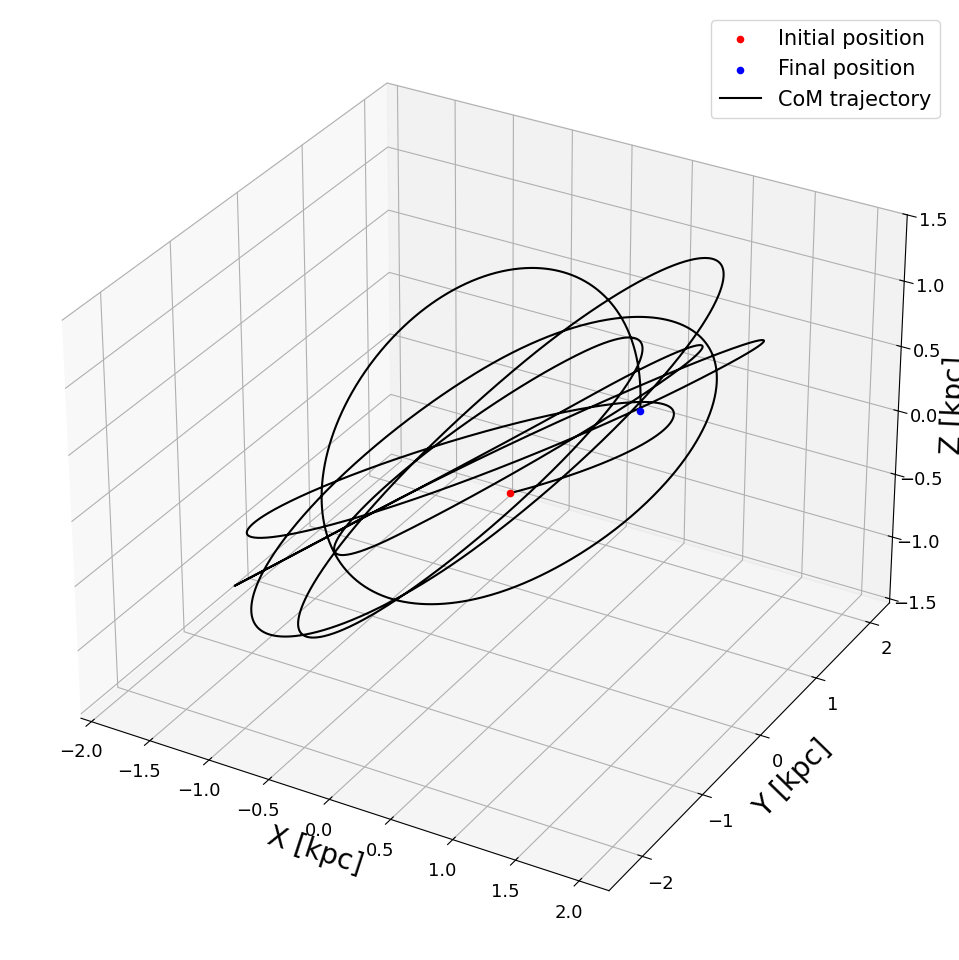

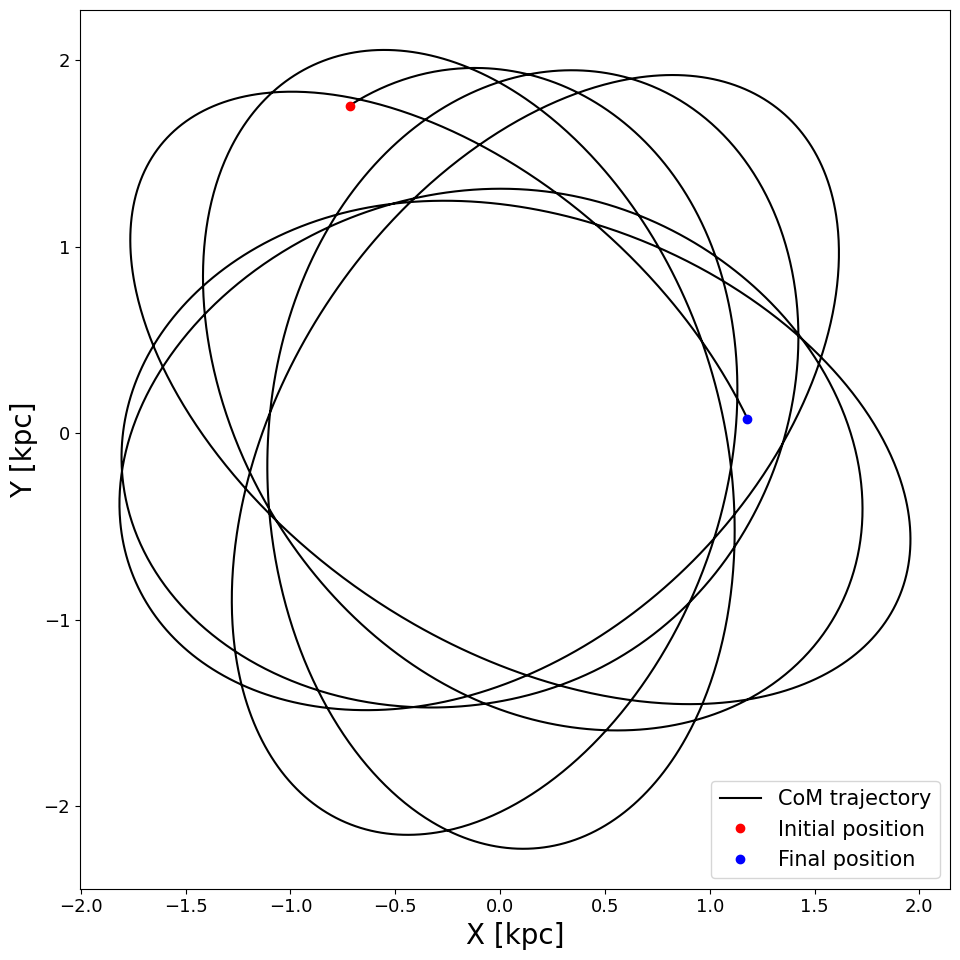

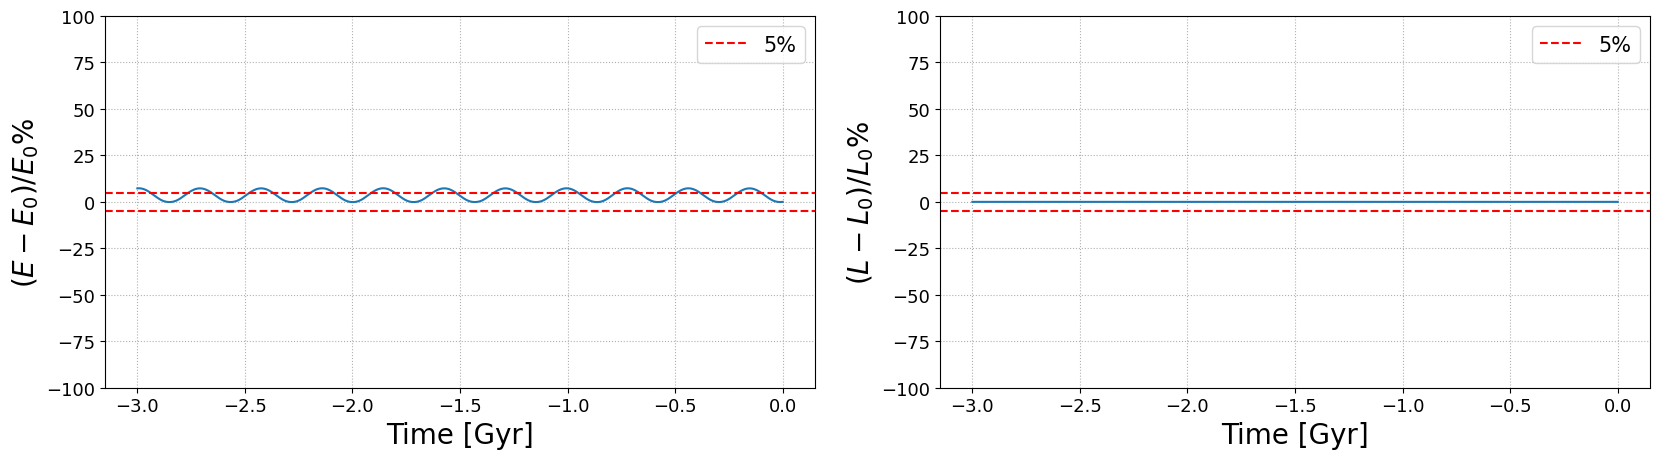

In [23]:
# Define the 
# Define the 
config_com = SimulationConfig(N_particles = 1, 
                          return_snapshots = True, 
                          num_snapshots = 5_000, 
                          num_timesteps = 10_000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC,
                          softening = (8 * u.pc).to(code_units.code_length).value) #default values

params_com = SimulationParams(t_end = -(3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
# pos_com_final = jnp.array([[12.4, 1.5, 7.1]]) * u.kpc.to(code_units.code_length)
# vel_com_final = jnp.array([[107.0, -243.0, -105.0]]) * (u.km/u.s).to(u.kpc/u.Myr)

mass_com = jnp.array([(10**4.05 * u.Msun).to(code_units.code_mass).value])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]

##### CoM orbit plot####
fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(snapshots_com.states[-1, 0, 0, 0], snapshots_com.states[-1, 0, 0, 1], snapshots_com.states[-1,0, 0, 2],c='r', label='Initial position')
ax.scatter(snapshots_com.states[0, 0, 0, 0], snapshots_com.states[0, 0, 0, 1], snapshots_com.states[0,0, 0, 2], c='b', label='Final position')
ax.plot(snapshots_com.states[:, 0, 0, 0], snapshots_com.states[:, 0, 0, 1], snapshots_com.states[:,0, 0, 2], 'k-', label='CoM trajectory')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_zlabel("Z [kpc]")
ax.legend()
plt.show()

fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0], snapshots_com.states[:, 0, 0, 1], 'k-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0], snapshots_com.states[-1, 0, 0, 1], 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0], snapshots_com.states[0, 0, 0, 1], 'bo', label='Final position')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.legend()

energy_angular_momentum_plot(snapshots_com, code_units,)

# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state = construct_initial_state(positions, velocities)

In [24]:
final_state_com.shape

(1, 2, 3)

In [25]:
pos = final_state_com[:, 0]
pos[:, :2]

Array([[1.1800001, 0.079    ]], dtype=float32)

In [26]:
snapshots_com.times * code_units.code_time.to(u.Myr)

Array([ 0.0000000e+00, -5.9999996e-01, -1.1999999e+00, ...,
       -2.9983604e+03, -2.9989604e+03, -2.9995605e+03], dtype=float32)

In [27]:
from odisseo.potentials import PowerSphericalPotentialwCutoff, NFW, MyamotoNagai, point_mass


# initial_state = construct_initial_state(positions, velocities)
initial_state = final_state_com

acc_PSP, pot_PSP = PowerSphericalPotentialwCutoff(initial_state,
                                     config,
                                     params,
                                     return_potential=True,)

acc_NFW, pot_NFW = NFW(initial_state,
                      config,
                      params,
                      return_potential=True,)

acc_MN, pot_MN = MyamotoNagai(initial_state,
                      config,
                      params,
                      return_potential=True,)

acc_point_mass, pot_point_mass = point_mass(initial_state,
                      config,
                      params,
                      return_potential=True,)

In [28]:
print(acc_PSP.shape, acc_NFW.shape, acc_MN.shape, acc_point_mass.shape)
print(pot_PSP.shape, pot_NFW.shape, pot_MN.shape, pot_point_mass.shape)
#run the simulation

(1, 3) (1, 3) (1, 3) (1, 3)
(1,) (1,) (1,) (1,)


In [29]:
acc_tot = acc_PSP + acc_NFW + acc_MN 
pot_tot = pot_PSP + pot_NFW + pot_MN

In [49]:
@jit
def cartesian_to_radial_acceleration(acc_xyz, pos_xyz):
    """
    Convert acceleration from Cartesian (x,y,z) to radial direction.
    
    Args:
        acc_xyz: acceleration vector in Cartesian coordinates (N, 3) or (3,)
        pos_xyz: position vector in Cartesian coordinates (N, 3) or (3,)
    
    Returns:
        acc_R: radial acceleration (scalar or array)
    """
    # Calculate radial distance
    r = jnp.linalg.norm(pos_xyz, axis=-1, keepdims=True)
    
    # Calculate radial unit vector
    r_hat = pos_xyz / r
    
    # Project acceleration onto radial direction
    acc_R = jnp.sum(acc_xyz @ r_hat.T, axis=-1)
    
    return acc_R

acc_R, acc_z = cartesian_to_radial_acceleration(acc_tot, final_state_com[:, 0]), acc_tot[:, 2]
print("Radial acceleration: ", acc_R )
print("Vertical acceleration: ", acc_z)

Radial acceleration:  [-3087.125]
Vertical acceleration:  [-1654.7837]


In [ ]:
from galpy import potential

pot_galpy = potential.MWPotential2014


acc_r = jnp.sum(jnp.array([pot.Rforce(R=jnp.linalg.norm(final_state_com[:, 0]*code_units.code_length.to(u.kpc) *u.kpc, ), z=final_state_com[:, 0, 2]*code_units.code_length.to(u.kpc)) *u.kpc for pot in pot_galpy])) 
print(acc_r)
acc_z_galpy = jnp.sum(jnp.array([pot.zforce(R=jnp.linalg.norm(final_state_com[:, 0]*code_units.code_length.to(u.kpc) *u.kpc, ), z=final_state_com[:, 0, 2]*code_units.code_length.to(u.kpc)) *u.kpc for pot in pot_galpy]))
print(acc_z_galpy)

-0.3828671
-0.013372649


In [53]:
acc_r_sun = jnp.sum(jnp.array([pot.Rforce(R=8.0*u.kpc, z=0.0)  for pot in pot_galpy]))
print("Radial acceleration at the Sun's position: ", acc_r_sun)

Radial acceleration at the Sun's position:  -1.0


In [ ]:
# a = jnp.array([1.,])

# @jit
# def return_a(a):
#     return jnp.squeeze(a)

# grad_return_a = jax.grad(return_a)

# grad_return_a(a)

In [ ]:
print('Initial position of the GD1 progenitor:', pos_com)
print('Radial distance of the progenitor:', jnp.linalg.norm(pos_com))
print('Initial velocity of the GD1 progenitor:', vel_com*code_units.code_velocity.to(u.km/u.s))


Initial position of the GD1 progenitor: [[-324.1649   781.628    283.45218]]
Radial distance of the progenitor: 892.3958
Initial velocity of the GD1 progenitor: [[ 109.49999  -254.49997   -90.299995]]


In [ ]:
#run the simulation
snapshots = jax.block_until_ready(time_integration(initial_state, mass, config, params))

ValueError: Incompatible shapes for broadcasting: (1000, 3) and requested shape (1, 3)

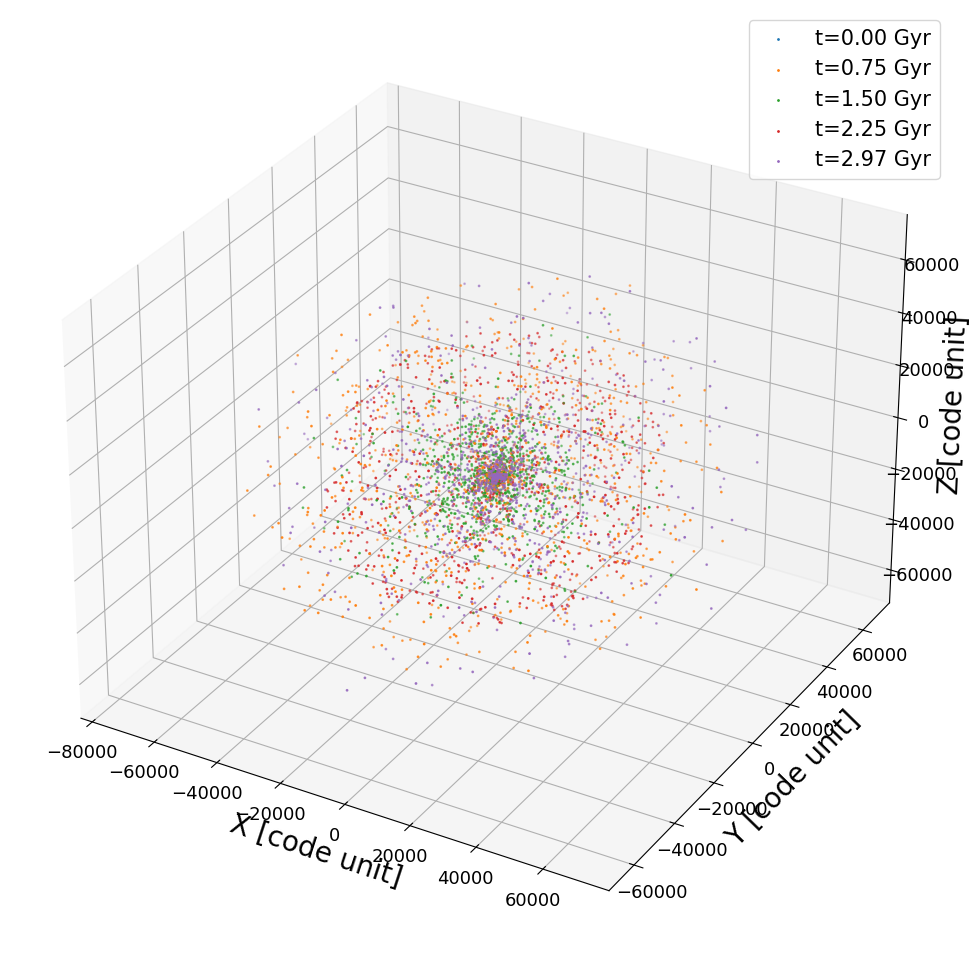

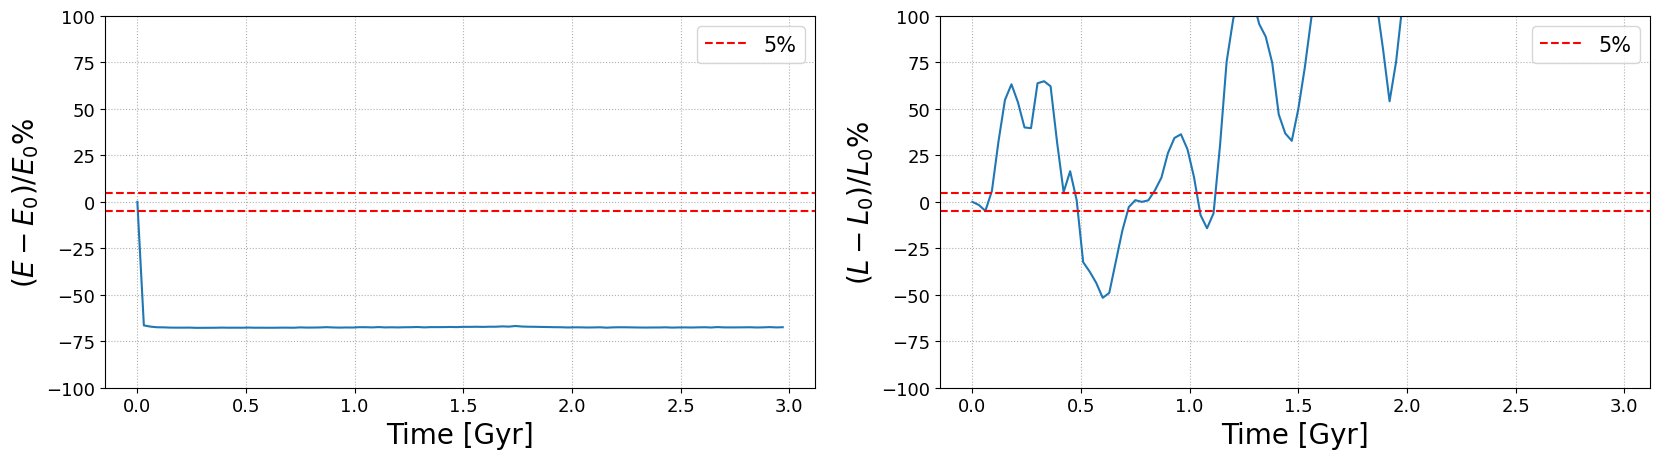

In [ ]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0], snapshots.states[i, :, 0, 1], snapshots.states[i, :, 0, 2], s=1,label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
ax.scatter(0, 0, 0, c='red', s=100, )
ax.set_xlabel('X [code unit]')
ax.set_ylabel('Y [code unit]')
ax.set_zlabel('Z [code unit]')
# ax.set_xlim(-30, 30)
# ax.set_ylim(-30, 30)
# ax.set_zlim(-30, 30)
ax.legend()


energy_angular_momentum_plot(snapshots, code_units,)


In [ ]:
final_state = snapshots.states[-1].copy()
final_positions, final_velocities = final_state[:, 0], final_state[:, 1]

# compute the trasformqation to the GD1 coordinate system for 1 star
gd1_coordinate = halo_to_gd1_all(final_positions[0], final_velocities[0], code_units)
print("GD1 coordinate: ", gd1_coordinate)

# compute the transformation to the GD1 coordinate system for all stars
gd1_coordinate_pos, gd1_coordinate_vel  = gd1_projection_vmap(final_positions, final_velocities, code_units)
print("shape of GD1 coordinate for all stars: ", gd1_coordinate_pos.shape)

GD1 coordinate:  (Array([ 1.5990024e+04,  1.2950559e+00, -3.6490867e-01], dtype=float32), Array([-8.803369e+01,  2.295943e-06, -1.803186e-06], dtype=float32))
shape of GD1 coordinate for all stars:  (1000, 3)


(-250.0, 250.0)

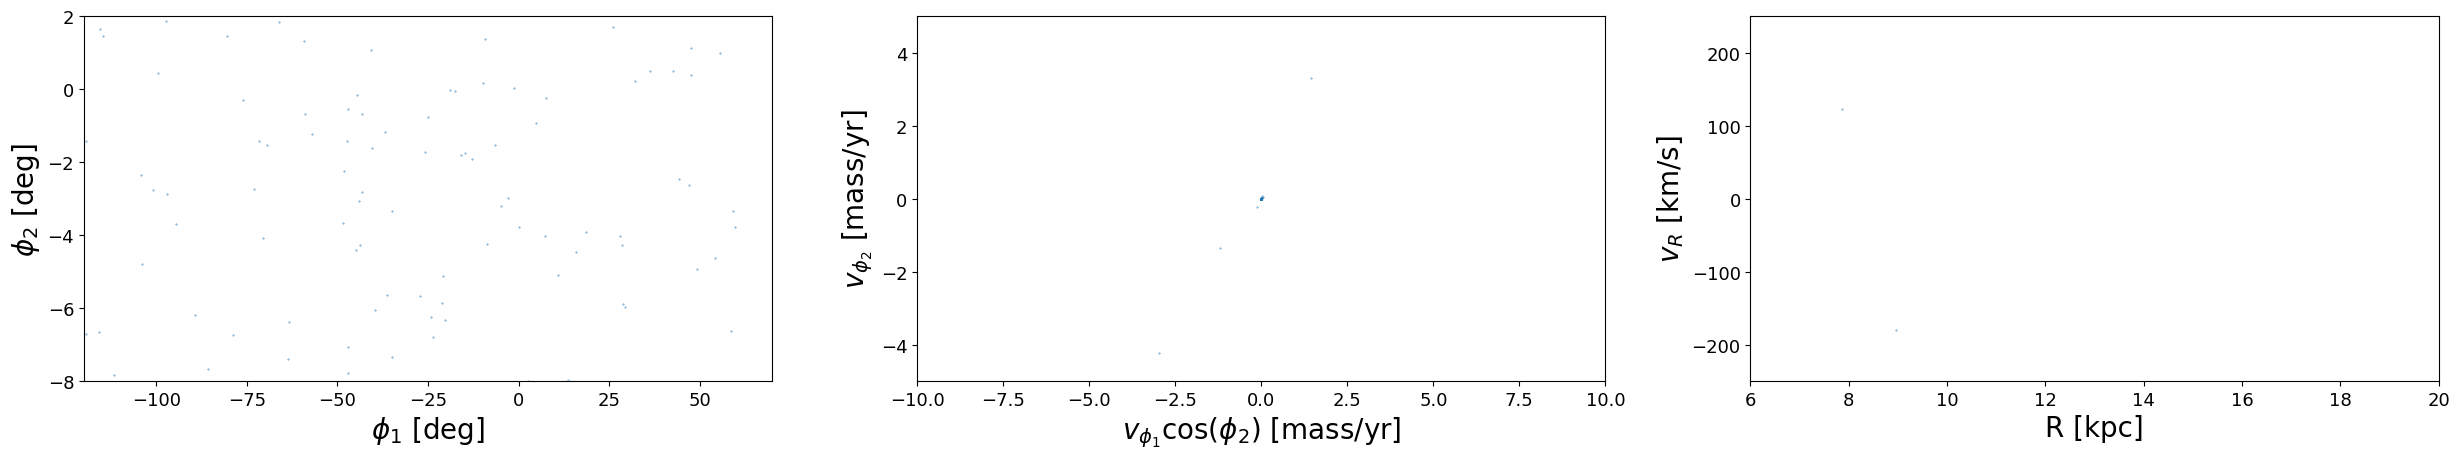

In [ ]:
phi1 = gd1_coordinate_pos[:, 1] #rad
phi2 = gd1_coordinate_pos[:, 2] #rad
v1 = gd1_coordinate_vel[:, 4] #kpc/Myr
v2 = gd1_coordinate_vel[:, 5] #kpc/Myr
R = gd1_coordinate_pos[:, 0] #kpc
vR = gd1_coordinate_vel[:, 3] #kpc/Myr

#unit conversion to kpc, mass/yr
v1 = v1/R * 2.0626480624709636e8 / 1e6
v2 = v2/R * 2.0626480624709636e8 / 1e6
vR = vR * (u.kpc/u.Myr).to(u.km/u.s)
phi1 = jnp.rad2deg(phi1)
phi2 = jnp.rad2deg(phi2)

fig = plt.figure(figsize=(25, 5), tight_layout=True)

ax = fig.add_subplot(131)
ax.scatter(phi1, phi2, s=0.1)
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)

ax = fig.add_subplot(132)
ax.scatter(v1 * jnp.cos(jnp.deg2rad(phi2)),
           v2 ,
            s=0.1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mass/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mass/yr]")
ax.set_xlim(-10, 10)
ax.set_ylim(-5, 5)
# ax.set_xlim(-2., 1.0)
# ax.set_ylim(-0.10, 0.10)

ax = fig.add_subplot(133)
ax.scatter(R, vR , s=0.1)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)


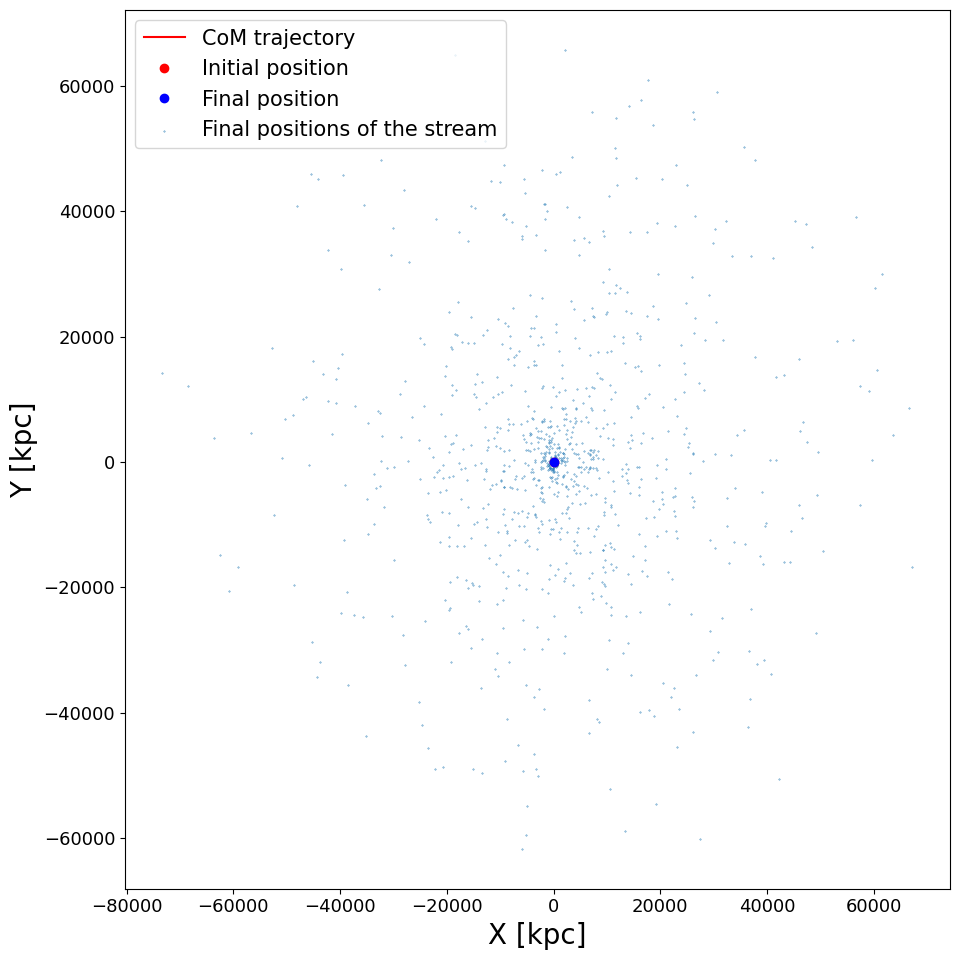

In [ ]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0], snapshots_com.states[:, 0, 0, 1], 'r-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0], snapshots_com.states[-1, 0, 0, 1], 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0], snapshots_com.states[0, 0, 0, 1], 'bo', label='Final position')
ax.scatter(snapshots.states[-1, :, 0, 0], snapshots.states[-1, :, 0, 1], s=0.1, label='Final positions of the stream')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
# ax.set_xlim(-30, 30)
# ax.set_ylim(-30, 30)
ax.legend()

In [ ]:
# from galpy.potential import NFWPotential

# @jit
# def calulcate_acceleration(state):
#     Nfw_potential = NFWPotential(amp=params.NFW_params.Mvir,
#                                   a=params.NFW_params.r_s)
#     acc_R = Nfw_potential._rforce_jax(jnp.linalg.norm(state[:, 0, :2], axis=1), )
#     # acc_z = Nfw_potential._zforce_jax(state[:, 0, 2], )
#     return acc_R

# calulcate_acceleration(snapshots.states[-1]).shape
    